# Tutorial 4: data integration for mouse brain Spatial-epigenome-transcriptome

In this tutorial, we demonstrate how to apply SpatialGlue to integrate Spatial-epigenome-transcriptome (Zhang et al.) data to obtain fine-grained clusters. Spatial-epigenome-transcriptome enables joint profiling of the epigenome and transcriptome by cosequencing chromtin accessibility and gene expression. As a example, we analyse a mouse brain P22 dataset. We collected the data from from AtlasXplore (https://web.atlasxomics.com/visualization/Fan). 

Before running the model, please download the input data via https://drive.google.com/drive/folders/1qO4KRAU7k942ktBkyiHMdvUuydWskeXO.

## Loading package

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc

/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from SpatialGlue import SpatialGlue

In [3]:
# Environment configuration. SpatialGlue pacakge can be implemented with either CPU or GPU. GPU acceleration is highly recommend for imporoved efficiency.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

## Loading data

In [4]:
# read data
file_fold = '/home/yahui/anaconda3/work/SpatialGlue_revision/data/Dataset7_Mouse_Brain1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_peaks_normalized.h5ad') 

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

# Pre-processing data
SpatialGlue adopts standard pre-processing steps for the transcriptomic and protein data. Specifically,for the transcriptomics data,the gene expression counts are log-transformed and normalized by library size via the SCANPY package. The top 3,000 highly variable genes (HVGs) are selected as input of PCA for dimension reduction. To ensure a consistent input dimension with the chromatin peak data, the first 50 principal components are retained and used as the input of the model. For the chromatin peak data, we used LSI (latent semantic indexing) to reduce the raw chromatin peak counts data to 50 dimensions. 

In [5]:
from SpatialGlue.preprocess import preprocessing
data = preprocessing(adata_omics1, adata_omics2, datatype='Spatial-epigenome-transcriptome')

## Training the model

The SpatialGlue model aims to learn an integrated latent representation by adaptively integrating expression profiles of different omics modalities in a spatially aware manner. 

After model training, SpatialGlue returns 'output' file. The 'output' file include multiple output results. Let's go through each of the results in more detail:

1. Latent Representations:

* 'emb_latent_omics1': latent representation for the first omics modality.

* 'emb_latent_omics2': latent representation for the second omics modality.

* 'SpatialGlue': joint representation learned by incorporating expression data and spatial location information.

   The joint representation can be used for downstream analysis such as clustering, visualization, or identifying differentially expressed genes (DEGs).

2. Attention Weight Values:

* 'alpha_omics1': intra-modality attention weight for the first omics modality, explaining the contribution of each graph to each cluster.

* 'alpha_omics2': intra-modality attention weight for the second omics modality, explaining the contribution of each graph to each cluster.

* 'alpha': inter-modality attention weight explaining the contribution of each modality to each cluster.

   These intra- and inter-modality attention weights provide interpretable insights into the importance of each neighborhood graph and modality to each cluster. 

In [6]:
# define model
model = SpatialGlue.SpatialGlue(data, datatype='Spatial-epigenome-transcriptome', device=device)

# train model
output = model.train()

  0%|                                                                                                                                                                                | 0/1600 [00:00<?, ?it/s]/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/SpatialGlue/model.py:150: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.alpha = F.softmax(torch.squeeze(self.vu) + 1e-6)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:42<00:00, 37.83it/s]

Model training finished!



In [8]:
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']

## Cross-omics integrative analysis

After integration, we perform clustering analysis using the joint representation. Here we provid three optional kinds of tools for clustering, including mclust, leiden, and louvain. In our experiment, we find 'mclust' algorithm performs better than 'leiden' and 'louvain' on spatial data in most cases. Therefore, we recommend using 'mclust' algorithm for clustering.

In [13]:
# we set 'mclust' as clustering tool by default. Users can also select 'leiden' and 'louvain'
from SpatialGlue.utils import clustering
tool = 'mclust' # mclust, leiden, and louvain
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=18, method=tool, use_pca=True) 

fitting ...
  |======================================================================| 100%


2023-12-14 17:13:13.187030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-14 17:13:13.963686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yahui/anaconda3/envs/STGAT/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


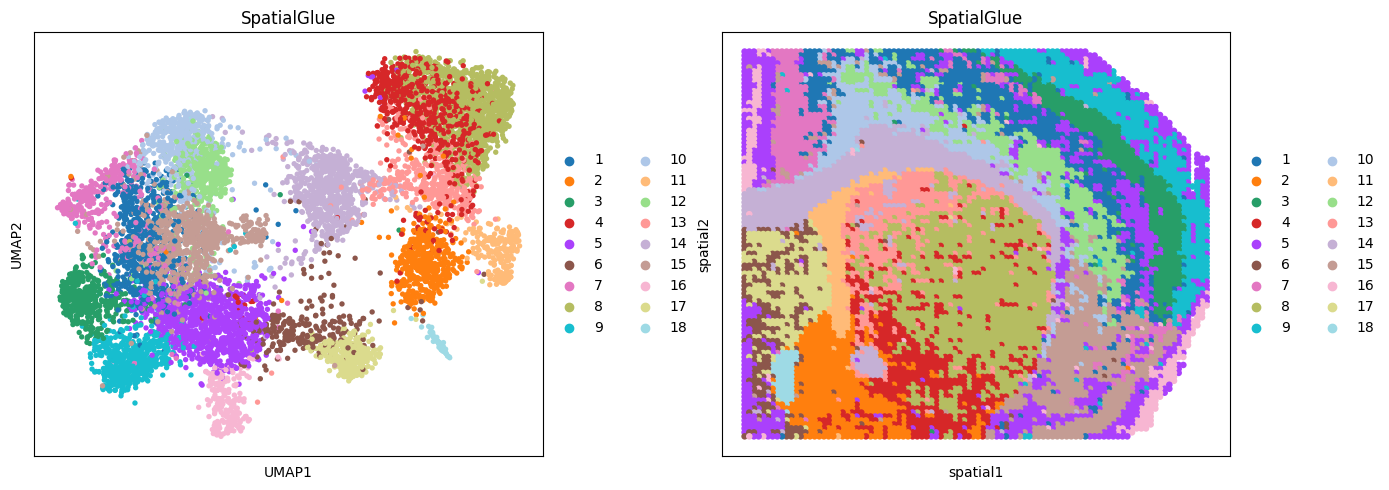

In [16]:
# visualization
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(14, 5))
sc.pp.neighbors(adata, use_rep='SpatialGlue', n_neighbors=30)
sc.tl.umap(adata)

sc.pl.umap(adata, color='SpatialGlue', ax=ax_list[0], title='SpatialGlue', s=60, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue', ax=ax_list[1], title='SpatialGlue', s=90, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()

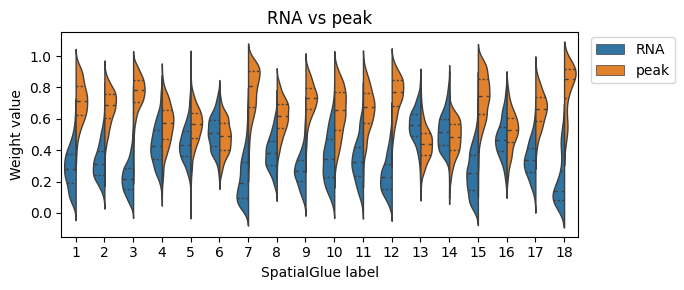

In [19]:
# plotting modality weight values. 
import pandas as pd  
import seaborn as sns
plt.rcParams['figure.figsize'] = (7,3)
df = pd.DataFrame(columns=['RNA', 'peak', 'label'])  
df['RNA'], df['peak'] = adata.obsm['alpha'][:, 0], adata.obsm['alpha'][:, 1]
df['label'] = adata.obs['SpatialGlue'].values
df = df.set_index('label').stack().reset_index()
df.columns = ['label_SpatialGlue', 'Modality', 'Weight value']
ax = sns.violinplot(data=df, x='label_SpatialGlue', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False)
ax.set_title('RNA vs peak')
ax.set_xlabel('SpatialGlue label')
ax.legend(bbox_to_anchor=(1.2, 1.01), loc='upper right')

plt.tight_layout(w_pad=0.05)
#plt.show()  